##IMPORTS

In [ ]:
pip install category_encoders
pip install imbalanced-learn

In [ ]:
import csv
import os
import sys
from collections import defaultdict

# Dask imports
import dask.dataframe as df  # Dask dataframes
from csv import reader

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split

sns.set_style('whitegrid') # sets the visual style of Seaborn plots to 'whitegrid', which displays a white background with grid lines.
sns.set_palette('pastel')  # sets the color palette to 'pastel', which is one of the predefined color palettes provided by Seaborn. It consists of a set of visually distinct colors suitable for plotting categorical data.



In [ ]:
# Mount Google Drive
from google.colab import drive #used to access files
drive.mount('/content/gdrive')

data_dir_train  = 'gdrive/My Drive/creditcard_data/fraudTrain.csv'
data_dir_test  = 'gdrive/My Drive/creditcard_data/fraudTest.csv'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#INITIALIZE DASK DATAFRAMES

In [ ]:
# Read CSV files into Dask DataFrames
train_df = df.read_csv(data_dir_train)
train_df = train_df.set_index('Unnamed: 0')
test_df = df.read_csv(data_dir_test)
test_df.set_index('Unnamed: 0')

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
npartitions=2,,,,,,,,,,,,,,,,,,,,,,
0,object,int64,object,object,float64,object,object,object,object,object,object,int64,float64,float64,int64,object,object,object,int64,float64,float64,int64
278054,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555718,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


#ANALYZE DATA

In [ ]:
train_df.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [ ]:
train_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 22 entries, trans_date_trans_time to is_fraud
dtypes: object(12), float64(5), int64(5)

In [ ]:
# Count the total number of missing values in the DataFrame
missing_values_count = train_df.isna().sum().sum().compute()
print("Total missing values:", missing_values_count)

Total missing values: 0


In [ ]:
# Count the duplicate rows in the DataFrame
duplicate_rows_count = train_df.groupby(train_df.columns.tolist()).size().reset_index()

# Filter out rows with count > 1 to get duplicate rows
duplicate_rows = duplicate_rows_count[duplicate_rows_count[0] > 1]

# Count the total number of duplicate rows
total_duplicate_rows_count = len(duplicate_rows)

# Display the count of duplicate rows
print("Total count of duplicate rows:", total_duplicate_rows_count)

Total count of duplicate rows: 0


We can assume that each transaction is unique given that there are no duplicate rows

In [ ]:
# Calculate value counts for "is_fraud" column
is_fraud = train_df["is_fraud"].value_counts()

# Trigger computation and retrieve results
is_fraud_result = is_fraud.compute()

# Print the counts
print("Yes:", is_fraud_result[1])
print("No:", is_fraud_result[0])

Yes: 7506
No: 1289169


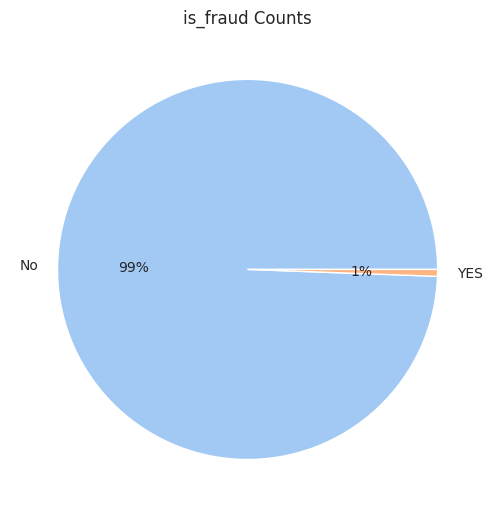

In [ ]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Data is unbalanced, we will undersample the majority class

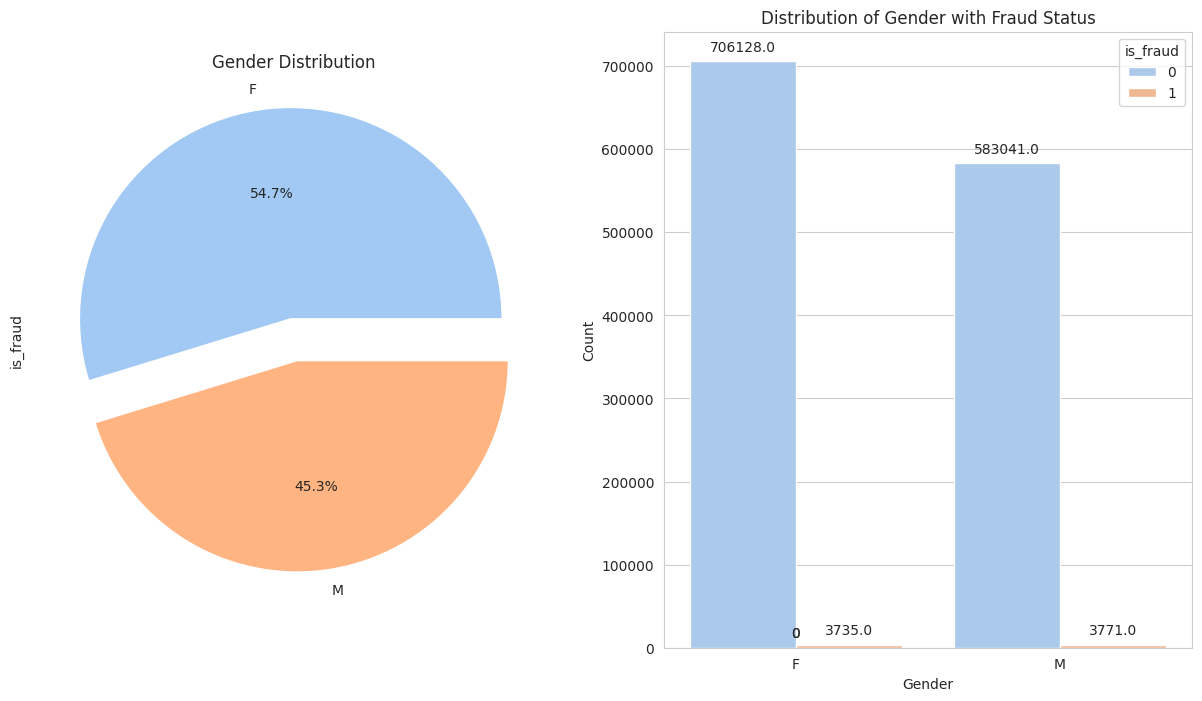

In [ ]:
# Create subplots
fig, axb = plt.subplots(ncols=2, nrows=1, figsize=(15, 8))

# Gender Distribution Pie Chart
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().compute().plot.pie(explode=explode, autopct="%1.1f%%", ax=axb[0])
axb[0].set_title("Gender Distribution")

# Gender Distribution Count Plot
ax = sns.countplot(x="gender", hue="is_fraud", data=train_df.compute(), ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
axb[1].set_title("Distribution of Gender with Fraud Status")
axb[1].set_xlabel("Gender")
axb[1].set_ylabel("Count")

# Show the plot
plt.show()

Females make more transactions however commit less fraudulent transactions when compared to males

#FEATURE ENGINEERING

In [ ]:
# Change date type from object to datetime
train_df['trans_date_trans_time'] = df.to_datetime(train_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
test_df['trans_date_trans_time'] = df.to_datetime(test_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1


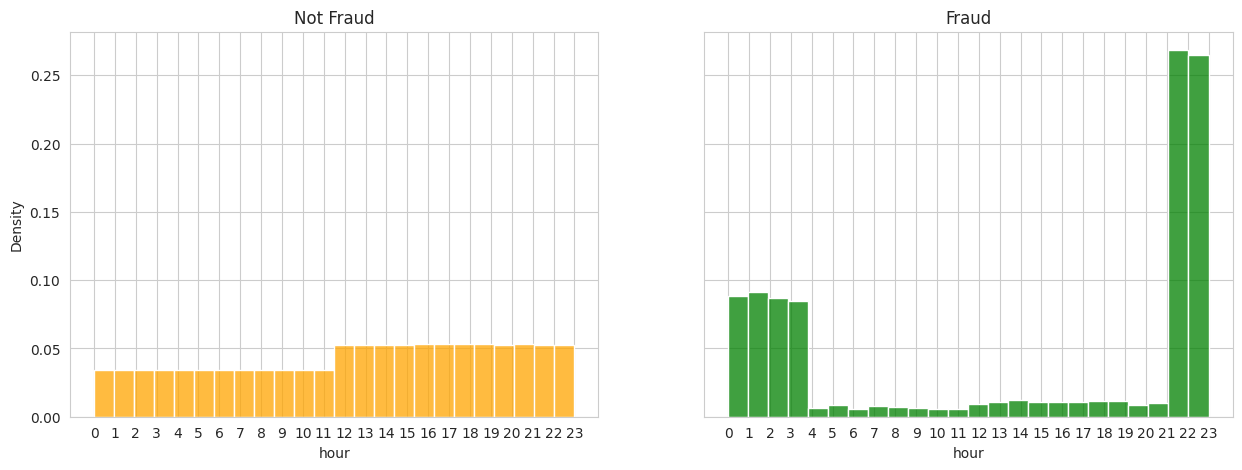

In [ ]:
import numpy as np
# Convert Dask DataFrame to Pandas DataFrame for plotting
train_df_pd = train_df.compute()

# Create subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

# Plot histogram for non-fraud transactions
sns.histplot(x='hour', data=train_df_pd[train_df_pd["is_fraud"] == 0],
             stat="density", bins=24, ax=ax1, color="orange")
ax1.set_title("Not Fraud")
ax1.set_xticks(np.arange(24))  # ticks of the day 0 -> 23

# Plot histogram for fraud transactions
sns.histplot(x='hour', data=train_df_pd[train_df_pd["is_fraud"] == 1],
             stat="density", bins=24, ax=ax2, color="green")
ax2.set_title("Fraud")
ax2.set_xticks(np.arange(24))  # ticks of the day 0 -> 23

plt.show()

We observe that fraudulent transactions more often occur during the last 2 hours of the day

###**DATA PREPROCESSING**

In [ ]:
# remove non-useful columns
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


In [ ]:
# #clean merchant column
# train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))

# Define a function to clean the 'merchant' column
def clean_merchant(x):
    return x.str.replace('fraud_', '')

# Define the meta parameter with the expected output type
meta = ('merchant', 'object')

# Apply the cleaning function to the 'merchant' column
train_df['merchant'] = train_df['merchant'].map_partitions(clean_merchant, meta=meta)

# Persist the changes
train_df = train_df.persist()

In [ ]:
train_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 14 entries, merchant to month
dtypes: object(5), float64(5), int64(4)

In [ ]:
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,
0,"Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,"Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


###**DATA ENCODING**

Perform categorical variable encoding using scikit-learn's LabelEncoder. It encodes categorical variables to numerical values for both training and testing data. The encoded encoders are saved using pickle. The purpose is to prepare categorical data for machine learning models, as many algorithms require numerical input.









In [ ]:
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder

def encode_partition(partition):
    encoder = LabelEncoder()
    partition = partition.fillna('missing')  # Fill missing values if any
    for col in partition.columns:
        if pd.api.types.is_string_dtype(partition[col]):
            partition[col] = encoder.fit_transform(partition[col])
    return partition

def encode(df):
    encoders = {}
    encoded_df = df.map_partitions(encode_partition)
    with open('LE_mdl_v1.pkl', 'wb') as f:
        pickle.dump(encoders, f)
    return encoded_df

train = encode(train_df)
test = encode(test_df)

In [ ]:
train.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,
0,514,8,4.97,18,0,36.0788,-81.1781,3495,360,36.011293,-82.048315,0,0,1
1,241,4,107.23,155,0,48.8878,-118.2105,149,416,49.159047,-118.186462,0,0,1


In [ ]:
test.head(2)

,Unnamed: 0,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,0,319,10,2.86,115,1,33.9659,-80.9355,333497,275,33.986391,-81.200714,0,12,6
1,1,591,10,29.84,457,0,40.3207,-110.4360,302,392,39.450498,-109.960431,0,12,6


##DEFINITION OF TRAINING SET

**UNDER SAMPLING**

In [ ]:
# Sample equal number of rows for each value of is_fraud
fraud_1_sampled = train[train['is_fraud'] == 1].sample(frac=7506/7506, random_state=42)
fraud_0_sampled = train[train['is_fraud'] == 0].sample(frac=7506/1289169, random_state=42)

# Concatenate the sampled groups
train_downsampled_df = df.concat([fraud_1_sampled, fraud_0_sampled])


In [ ]:
# Calculate value counts for "is_fraud" column
is_fraud_downsampled = train_downsampled_df["is_fraud"].value_counts()

# Trigger computation and retrieve results
is_fraud_result_downsampled = is_fraud_downsampled.compute()

# Print the counts
print("Yes:", is_fraud_result_downsampled[1])
print("No:", is_fraud_result_downsampled[0])

Yes: 7506
No: 7506


In [ ]:
# Assuming df is your Dask dataframe
num_partitions = train_downsampled_df.npartitions
print("Number of partitions:", num_partitions)

Number of partitions: 10


**OVER SAMPLING**

0    1289169
1    1289169
Name: is_fraud, dtype: int64

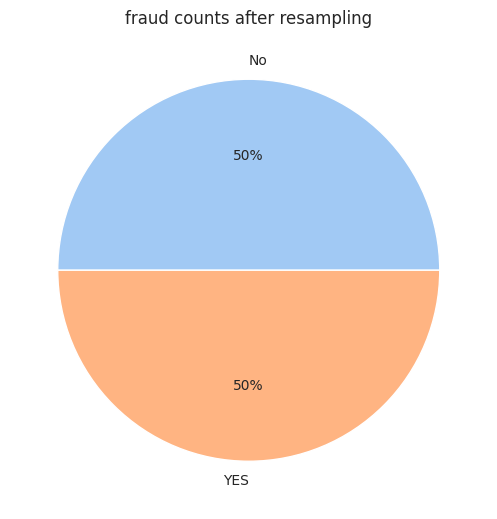

In [ ]:
"""
In this part we will oversample our data set using SMOTE
and then plotting the data in a pie graph to see compare
the amount of data that was generated in comparison to
undersampling.

"""

df_no_fraud = train.drop('is_fraud', axis=1)
df_fraud= train['is_fraud']
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(df_no_fraud, df_fraud)

df_X = pd.DataFrame(X, columns=df_no_fraud.columns)
df_y= pd.DataFrame(y, columns=['is_fraud'])
concat_df = pd.concat([df_X, df_y], axis=1)
train_oversampled_df = df.from_pandas(concat_df, npartitions=10)

oversampled_is_fraud = train_oversampled_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.pie(oversampled_is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("fraud counts after resampling")
plt.tight_layout()

train_oversampled_df["is_fraud"].value_counts().compute()

#MODEL TRAINING

In [ ]:
pip install dask dask-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00


**Common functions to train and evaluate models**

In [ ]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate_model(train_df, test_df, target_column, model, model_filename, **hyperparameters):
    # Drop 'Unnamed: 0' column if it exists in train and test dataframes
    if 'Unnamed: 0' in train_df.columns:
        train_df = train_df.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in test_df.columns:
        test_df = test_df.drop(columns=['Unnamed: 0'])

    # Split the training data into features and target
    X_train = train_df.drop(target_column, axis=1)
    y_train = train_df[target_column]

    # Instantiate the logistic regression model
    model = model(**hyperparameters)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Save the trained model
    joblib.dump(model, model_filename+".joblib")

    # Split the test data into features and target
    X_test = test_df.drop(target_column, axis=1)
    y_test = test_df[target_column]

    # Predict on the test set
    y_pred = model.predict(X_test)

    return y_test, y_pred

def get_model_eval_reports(y_test, y_pred):
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [ ]:
## Training Logistics Regression Model with Undersampled and Oversampled datasets

from sklearn.linear_model import LogisticRegression

hyperparameters = {'max_iter': 10000}
lr_us_y_test, lr_us_y_pred = train_and_evaluate_model(train_downsampled_df, test, 'is_fraud', LogisticRegression, 'LogisticRegressionUndersampled', **hyperparameters)
lr_os_y_test, lr_os_y_pred = train_and_evaluate_model(train_oversampled_df, test, 'is_fraud', LogisticRegression, 'LogisticRegressionOversampled', **hyperparameters)
# get_model_eval_reports(lr_us_y_test, lr_us_y_pred)
# get_model_eval_reports(lr_os_y_test, lr_os_y_pred)

Accuracy: 0.9498127650845122
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.06      0.75      0.10      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719

Accuracy: 0.9501798570860452
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.06      0.75      0.10      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719



In [ ]:
## Training Random Forest Model with Undersampled dataset

from sklearn.ensemble import RandomForestClassifier

hyperparameters = {'n_estimators': 100, 'random_state': 42}
rf_us_y_test, rf_us_y_pred = train_and_evaluate_model(train_downsampled_df, test, 'is_fraud', RandomForestClassifier, 'RandomForestClassifierUndersampled', **hyperparameters)
# get_model_eval_reports(rf_us_y_test, rf_us_y_pred)

Accuracy: 0.9741685995979983
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    553574
           1       0.12      0.94      0.22      2145

    accuracy                           0.97    555719
   macro avg       0.56      0.96      0.60    555719
weighted avg       1.00      0.97      0.98    555719



In [ ]:
## Training XGBoost Model with Undersampled dataset

from xgboost import XGBClassifier

hyperparameters = {'use_label_encoder': False, 'eval_metric': 'logloss'}
xg_us_y_test, xg_us_y_pred = train_and_evaluate_model(train_downsampled_df, test, 'is_fraud', XGBClassifier, 'XGBClassifierUndersampled', **hyperparameters)

# get_model_eval_reports(xg_us_y_test, xg_us_y_pred)

Accuracy: 0.9751870999551931
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.13      0.96      0.23      2145

    accuracy                           0.98    555719
   macro avg       0.56      0.97      0.61    555719
weighted avg       1.00      0.98      0.98    555719



**Oversampled Data Model Training**

In [ ]:
"""
In this part we train our oversampled datat obtained from SMOTE.
The data is trained the same way as the undersampled data using logestic regression, random forest and XGB

Information:
Random Forest model training takes a significant amount of time.

"""

hyperparameters = {"max_iter": 10000}
logestic_regression_test, logestic_regression_predection = train_and_evaluate_model(train_oversampled_df, test, "is_fraud", LogisticRegression, "LogisticRegressionOversampled", **hyperparameters)
get_model_eval_reports(logestic_regression_test, logestic_regression_predection)

"""
hyperparameters = {"n_estimators": 100, "random_state": 42}
random_forest_test, random_forest_predection = train_and_evaluate_model(train_oversampled_df, test, "is_fraud", RandomForestClassifier, "RandomForestOversampled", **hyperparameters)
get_model_eval_reports(random_forest_test, random_forest_predection)
"""

hyperparameters = {"use_label_encoder": False, "eval_metric": "logloss"}
xgboost_test, xgboost_predection = train_and_evaluate_model(train_oversampled_df, test, "is_fraud", XGBClassifier, "XgbOversampled", **hyperparameters)
get_model_eval_reports(xgboost_test, xgboost_predection)

#FINETUNING MODEL

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

def train_with_multiple_params(train_df_passed, test_df_passed, target_column, model, model_filename, param_grid, cv=5):

    if isinstance(train_df_passed, pd.DataFrame):
        train_df = train_df_passed
    else:
        train_df = train_df_passed.compute()

    if isinstance(test_df_passed, pd.DataFrame):
        test_df = test_df_passed
    else:
        test_df = test_df_passed.compute()

    # train_df = train_df_passed.compute()
    # test_df = test_df_passed.compute()

    # Drop 'Unnamed: 0' column if it exists in train and test dataframes
    if 'Unnamed: 0' in train_df.columns:
        train_df = train_df.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in test_df.columns:
        test_df = test_df.drop(columns=['Unnamed: 0'])

    # Split the training data into features and target
    X_train = train_df.drop(target_column, axis=1)
    y_train = train_df[target_column]

    # Instantiate the model
    model_instance = model()

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(model_instance, param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Save the trained model
    # joblib.dump(best_model, model_filename+".joblib")

    # Print parameters passed for the best model
    print("Parameters passed for the best model:")
    print(grid_search.best_params_)

    # Print details of the best model
    # print("Best Model Hyperparameters:")
    # print(best_model.get_params())  # Print hyperparameters
    # if isinstance(model_instance, LogisticRegression):
    #     print("Logistic Regression Coefficients:")
    #     print(best_model.coef_)  # Print coefficients if it's a Logistic Regression model

    # Split the test data into features and target
    X_test = test_df.drop(target_column, axis=1)
    y_test = test_df[target_column]

    # Predict on the test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{best_model.__class__.__name__} Accuracy:", accuracy)

    # Print the classification report
    print(f"{best_model.__class__.__name__} Classification Report:")
    print(classification_report(y_test, y_pred))

    return y_test, y_pred

In [ ]:

param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'max_iter': [100, 500, 1000]
}

train_with_multiple_params(train_downsampled_df, test, 'is_fraud', LogisticRegression, 'logistic_regression_model', param_grid)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Parameters passed for the best model:
{'C': 1.0, 'max_iter': 500}
Best Model Hyperparameters:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Logistic Regression Coefficients:
[[-2.40360539e-04 -9.71094573e-04  7.75790870e-03 -6.03005209e-04
  -3.69488625e-05 -2.62337210e-03  5.94802296e-03 -3.85984459e-08
   1.85201516e-04 -2.62419367e-03  5.94161959e-03 -1.49760612e-03
  -7.75959263e-04]]
LogisticRegression Accuracy: 0.9498127650845122
LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.06      0.75      0.10      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg   

(0         0
 1         0
 2         0
 3         0
 4         0
          ..
 277660    0
 277661    0
 277662    0
 277663    0
 277664    0
 Name: is_fraud, Length: 555719, dtype: int64,
 array([0, 0, 0, ..., 0, 0, 0]))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define param_grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

train_with_multiple_params(train_downsampled_df, test, 'is_fraud', RandomForestClassifier, 'random_forest_model', param_grid_rf)

Parameters passed for the best model:
{'max_depth': 15, 'n_estimators': 300}
Best Model Hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
RandomForestClassifier Accuracy: 0.9730889172405478
RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    553574
           1       0.12      0.94      0.21      2145

    accuracy                           0.97    555719
   macro avg       0.56      0.96      0.60    555719
weighted avg       1.00      0.97      0.98    555719



(0         0
 1         0
 2         0
 3         0
 4         0
          ..
 277660    0
 277661    0
 277662    0
 277663    0
 277664    0
 Name: is_fraud, Length: 555719, dtype: int64,
 array([0, 0, 0, ..., 0, 1, 0]))

In [ ]:
from xgboost import XGBClassifier

# Define param_grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

train_with_multiple_params(train_downsampled_df, test, 'is_fraud', XGBClassifier, 'XGBoost_model', param_grid_xgb)

Parameters passed for the best model:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
XGBClassifier Accuracy: 0.9764431304310272
XGBClassifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.14      0.96      0.24      2145

    accuracy                           0.98    555719
   macro avg       0.57      0.97      0.61    555719
weighted avg       1.00      0.98      0.99    555719



(0         0
 1         0
 2         0
 3         0
 4         0
          ..
 277660    0
 277661    0
 277662    0
 277663    0
 277664    0
 Name: is_fraud, Length: 555719, dtype: int64,
 array([0, 0, 0, ..., 0, 1, 0]))

#EVALUATION METRICS VISUALIZATION

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def get_model_metrics(y_test_list, y_pred_list, labels):
    accuracy_scores = [accuracy_score(y_test, y_pred) for y_test, y_pred in zip(y_test_list, y_pred_list)]
    precision_scores = [precision_score(y_test, y_pred) for y_test, y_pred in zip(y_test_list, y_pred_list)]
    recall_scores = [recall_score(y_test, y_pred) for y_test, y_pred in zip(y_test_list, y_pred_list)]
    f1_scores = [f1_score(y_test, y_pred) for y_test, y_pred in zip(y_test_list, y_pred_list)]

    metrics_dict = {
        'Accuracy': accuracy_scores,
        'Precision': precision_scores,
        'Recall': recall_scores,
        'F1-score': f1_scores
    }
    return metrics_dict

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(metrics_dict):
    # Define colors if not provided
    if colors is None:
        colors = plt.cm.get_cmap('tab10', len(model_names))

    # Plotting bar graphs for each metric
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    axs = axs.ravel()

    for idx, (metric, scores) in enumerate(metrics_dict.items()):
        axs[idx].bar(labels, scores)
        axs[idx].set_xlabel('Test Samples')
        axs[idx].set_ylabel(metric)
        axs[idx].set_title(f'{metric} vs Test Samples')
        axs[idx].grid(True)

    plt.show()

In [ ]:
y_test_list = [lr_us_y_test, rf_us_y_test, xg_us_y_test]
y_pred_list = [lr_us_y_pred, rf_us_y_pred, xg_us_y_pred]
labels = ['LogisticRegression', 'RandomForest', 'XGBoost']  # Labels for each test case

metrics_dict = get_model_metrics(y_test_list, y_pred_list, labels)

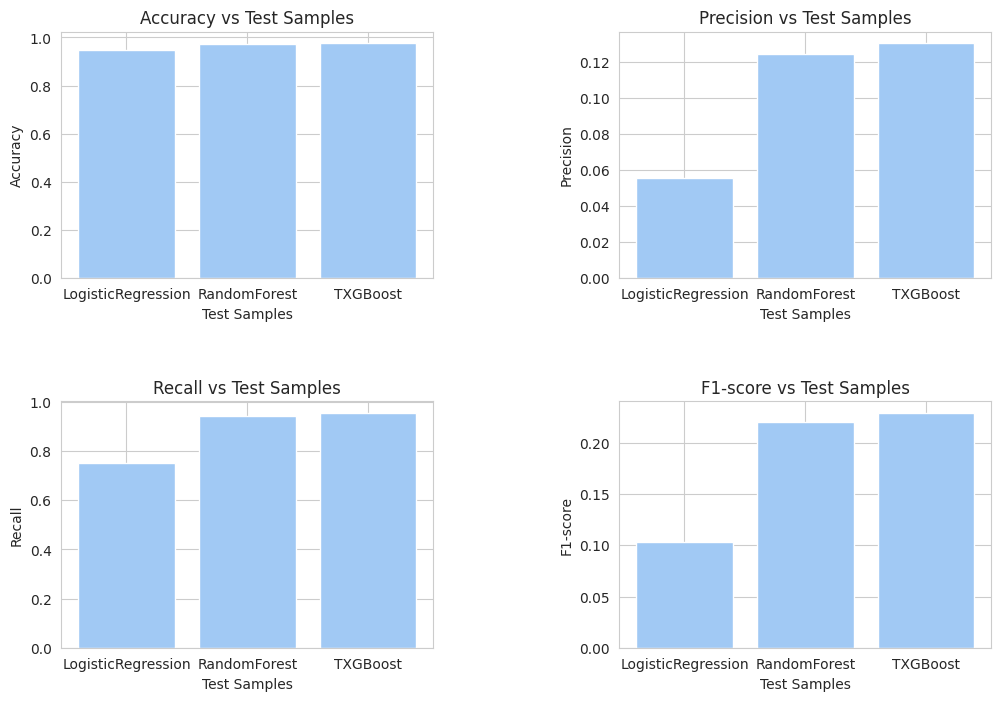

In [ ]:
plot_graphs(metrics_dict)

**Oversampled Data Model Evaluation**

In [ ]:
"""
In this part we will evaluate the metrics of our oversampled data using
accuracy, precision, recall and f1 as the metrucs for evaluating the model
of the oversampled data.
Only the Logestic regression and the XGB boost model are evaluated, because
the Random Forest model of the oversampled data takes a very long time to
train
"""

y_test_list = [logestic_regression_test, xgboost_test]
y_pred_list = [logestic_regression_predection, xgboost_predection]
labels = ['LogisticRegression', 'XGBoost']

metrics_dict = get_model_metrics(y_test_list, y_pred_list, labels)
plot_graphs(metrics_dict)